In [43]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

In [157]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, E  = sp.symbols('a b x g p E')

In [158]:
f0p0high = p1 / (1-sp.exp(-b)) * sp.integrate(sp.exp(-x), (x, b, sp.oo))
f0p0high

p_1*exp(-b)/(1 - exp(-b))

In [159]:
integrand = p1 * sp.exp(-x) * (sp.exp(-b+x) + a*(1-sp.exp(-b+x)) + (1-a)*(1-sp.exp(-b+x))*(a+(1-a)*g)) / (1-sp.exp(-b))
f0p0low = sp.integrate(integrand, (x,0,b))
f0p0low

b*(-a**2*g*p_1 + a**2*p_1 + 2*a*g*p_1 - 2*a*p_1 - g*p_1 + p_1)/(exp(b) - 1) + Piecewise((-(-a**2*g*p_1*exp(b) + a**2*p_1*exp(b) + 2*a*g*p_1*exp(b) - 2*a*p_1*exp(b) - g*p_1*exp(b))/(exp(b) - 1) + (-a**2*g*p_1*exp(b) + a**2*p_1*exp(b) + 2*a*g*p_1*exp(b) - 2*a*p_1*exp(b) - g*p_1*exp(b))*exp(-b)/(exp(b) - 1), Ne(b, 0)), (b*(-(-a**2*g*p_1 + a**2*p_1 + 2*a*g*p_1 - 2*a*p_1 - g*p_1 + p_1)/(exp(b) - 1) + (a**2*g*p_1*exp(b) - a**2*g*p_1 - a**2*p_1*exp(b) + a**2*p_1 - 2*a*g*p_1*exp(b) + 2*a*g*p_1 + 2*a*p_1*exp(b) - 2*a*p_1 + g*p_1*exp(b) - g*p_1 + p_1)/(exp(b) - 1)), True))

In [160]:
f0pp0p     = a*(1-a)*p1
f0ppp0pp   = a**2*p1
f1p1       = a*(2-a)*p1
fRestpRest = p1*2*(1-a)*a**2 / ((1-a)*(1-2*a))
fRestpRest

2*a**2*p_1/(1 - 2*a)

In [161]:
full = f0p0low + f0p0high + f0pp0p + f0ppp0pp + f1p1 + fRestpRest
full = sp.simplify(full)
full

Piecewise((-p_1*(2*a**2*(exp(b) - 1) + (2*a - 1)*(b*(a**2*g - a**2 - 2*a*g + 2*a + g - 1) - 1) - (2*a - 1)*(exp(b) - 1)*(a**2*g - 2*a*g - a*(a - 2) - a*(a - 1) + 2*a + g))/((2*a - 1)*(exp(b) - 1)), (b > 0) | (b < 0)), (-p_1*(2*a**2*(exp(b) - 1) + (2*a - 1)*(b*(a**2*g - a**2 - 2*a*g + 2*a + g - 1) - 1) + (2*a - 1)*(a*(1 - exp(b))*(3 - a) - b*(a**2*g - a**2 - 2*a*g + 2*a + g)*exp(b)))/((2*a - 1)*(exp(b) - 1)), True))

In [162]:
p0pp  = a*p1
p0p   = (1-a)*p1
p0    = p1 / (a*(1-sp.exp(-b)))
pRest = (1-a)*a/((1-a)*(1-2*a)) * p1

In [163]:
p1solved = sp.solve(sp.Eq(p0 + p0p + p0pp + p1 + pRest, 1), p1)[0]
p1solved

a*(2*a*exp(b) - 2*a - exp(b) + 1)/(3*a**2*exp(b) - 3*a**2 + 2*a - exp(b))

In [164]:
final = sp.simplify(full.evalf(subs={p1:p1solved}))
final

Piecewise((a*(-2.0*a**2*(exp(b) - 1) - (2.0*a - 1.0)*(b*(a**2*g - a**2 - 2.0*a*g + 2.0*a + g - 1.0) - 1.0) + (2.0*a - 1.0)*(exp(b) - 1.0)*(a**2*g - 2.0*a*g - a*(a - 2.0) - a*(a - 1.0) + 2.0*a + g))*(2.0*a*exp(b) - 2.0*a - exp(b) + 1.0)/((2.0*a - 1.0)*(exp(b) - 1.0)*(3.0*a**2*exp(b) - 3.0*a**2 + 2.0*a - exp(b))), (b > 0) | (b < 0)), (-a*(2.0*a**2*(exp(b) - 1) + (2.0*a - 1.0)*(b*(a**2*g - a**2 - 2.0*a*g + 2.0*a + g - 1.0) - 1.0) + (2.0*a - 1.0)*(a*(a - 3.0)*(exp(b) - 1.0) - b*(a**2*g - a**2 - 2.0*a*g + 2.0*a + g)*exp(b)))*(2.0*a*exp(b) - 2.0*a - exp(b) + 1.0)/((2.0*a - 1.0)*(exp(b) - 1.0)*(3.0*a**2*exp(b) - 3.0*a**2 + 2.0*a - exp(b))), True))

In [165]:
finalLambda = sp.lambdify((a, b, g), final)
finalLambda

<function _lambdifygenerated(a, b, g)>

In [166]:
def Carlsten(alpha, beta, gamma=0):
    num1 = 1 + (beta * np.power(1-alpha,2) * (1-gamma))
    den1 = np.exp(beta) - 1
    exp1 = num1 / den1
    
    exp2 = exp1 + (5 * alpha) + (np.power(1-alpha, 2) * gamma) 
    exp3 = (2 * np.power(alpha, 2)) / (1-2 * alpha) - (2 * np.power(alpha,2))
    
    exp4 = exp2 + exp3
    
    num2 = alpha * (1-2*alpha) * (1 - np.exp(-beta))
    den2 = 1 - 2 * np.exp(-beta) * alpha - 3 * (1 - np.exp(-beta)) * np.power(alpha,2)
    
    exp5 = num2 / den2
    
    return exp4 * exp5

In [167]:
alpha  = 0.33
betas  = np.arange(0.1, 10, 0.01)
gammas = [0., 0.5, 1.]

resMines = []
resTheir = []
for g in gammas:
    resMines.append(finalLambda(alpha, betas, g))
    resTheir.append(Carlsten(alpha, betas, g))

# MINE NEW

In [272]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, E  = sp.symbols('a b x g p E')

In [273]:
# ps should be the same
p0    = p1 / (a*(1-sp.exp(-b)))
p0p   = p1 * (1-a)
p0pp  = p1 * a
prest = p1*a/(1-2*a)

In [274]:
eq = sp.Eq(p0+p0p+p0pp+prest+p1, 1)
p1_sym = sp.solve(eq, p1)[0]

In [275]:
p1them = a*(2*a-1)*(sp.exp(b)-1)/(3*a**2*(sp.exp(b)-1)+ 2*a-sp.exp(b))
p1them

a*(2*a - 1)*(exp(b) - 1)/(3*a**2*(exp(b) - 1) + 2*a - exp(b))

In [276]:
p1_sym

a*(2*a*exp(b) - 2*a - exp(b) + 1)/(3*a**2*exp(b) - 3*a**2 + 2*a - exp(b))

In [277]:
p1_sym.evalf(subs={a:0.3, b:1}), p1them.evalf(subs={a:0.3, b:1})

(0.124637683091749, 0.124637683091749)

In [278]:
p0    = p1 / (a*(1-sp.exp(-b)))
p0p   = p1 * (1-a)
p0pp  = p1 * a
p2    = p1 * (a/(1-a))
p3    = p1 * (a/(1-a))**2
p4    = p1 * (a/(1-a))**3
p5    = p1 * (a/(1-a))**4
p6    = p1 * (a/(1-a))**5
p7    = p1 * (a/(1-a))**7

In [279]:
(p0 + p0p + p0pp + p1+  p2+ p3 + p4+ p5+ p6 + p7).evalf(subs={a:0.3, b:1, p1:p1_sym.evalf(subs={a:0.3, b:1})})

0.998979454556097

$$
f_0 = \alpha (\beta+1) e^{-\beta} + \alpha^2 (1-(\beta+1) e^{-\beta}) +\alpha(1-\alpha)(\alpha+\gamma(1-\alpha)) (1-(\beta+1) e^{-\beta})
$$

In [302]:
f0 = a*(b+1)*sp.exp(-b) + a**2*(1-(b+1)*sp.exp(-b)) + a*(1-a)*(a+g*(1-a))*(1-(b+1)*sp.exp(-b))
f0

a**2*(-(b + 1)*exp(-b) + 1) + a*(1 - a)*(a + g*(1 - a))*(-(b + 1)*exp(-b) + 1) + a*(b + 1)*exp(-b)

In [259]:
# TEST
f0p  = a
f0pp = a
f1   = a + a*(1-a)
f2   = a + a*(1-a)
f3   = a + a*(1-a) + a*(1-a)**2
f4   = a + a*(1-a) + a*(1-a)**2
f5   = a + a*(1-a) + a*(1-a)**2 + a*(1-a)**3
f6   = a + a*(1-a) + a*(1-a)**2 + a*(1-a)**3 + a*(1-a)**4
f7   = a + a*(1-a) + a*(1-a)**2 + a*(1-a)**3 + a*(1-a)**4 + a*(1-a)**5

In [303]:
f0p  = a
f0pp = a
f1   = a + 2*a*(1-a)
f2   = a + 2*a*(1-a)
f3   = a + 2*a*(1-a) + 3*a*(1-a)**2
f4   = a + 2*a*(1-a) + 3*a*(1-a)**2
f5   = a + 2*a*(1-a) + 3*a*(1-a)**2 + 4*a*(1-a)**3
f6   = a + 2*a*(1-a) + 3*a*(1-a)**2 + 4*a*(1-a)**3 + 5*a*(1-a)**4
f7   = a + 2*a*(1-a) + 3*a*(1-a)**2 + 4*a*(1-a)**3 + 5*a*(1-a)**4 + 6*a*(1-a)**5

In [304]:
full = p0*f0 + p0p*f0p + p0pp*f0pp + p1*f1 + p2*f2 + p3*f3 + p4*f4 + p5*f5 + p6*f6 + p7*f7 
full

a**7*p_1*(6*a*(1 - a)**5 + 5*a*(1 - a)**4 + 4*a*(1 - a)**3 + 3*a*(1 - a)**2 + 2*a*(1 - a) + a)/(1 - a)**7 + a**5*p_1*(5*a*(1 - a)**4 + 4*a*(1 - a)**3 + 3*a*(1 - a)**2 + 2*a*(1 - a) + a)/(1 - a)**5 + a**4*p_1*(4*a*(1 - a)**3 + 3*a*(1 - a)**2 + 2*a*(1 - a) + a)/(1 - a)**4 + a**3*p_1*(3*a*(1 - a)**2 + 2*a*(1 - a) + a)/(1 - a)**3 + a**2*p_1 + a**2*p_1*(3*a*(1 - a)**2 + 2*a*(1 - a) + a)/(1 - a)**2 + a*p_1*(1 - a) + a*p_1*(2*a*(1 - a) + a)/(1 - a) + p_1*(2*a*(1 - a) + a) + p_1*(a**2*(-(b + 1)*exp(-b) + 1) + a*(1 - a)*(a + g*(1 - a))*(-(b + 1)*exp(-b) + 1) + a*(b + 1)*exp(-b))/(a*(1 - exp(-b)))

In [305]:
final = sp.simplify(full.evalf(subs={p1:p1_sym}))
final

0.333333333333333*a*(2.0*a*exp(b) - 2.0*a - exp(b) + 1.0)*(a**8*(1.0*exp(b) - 1)*(2.0*a + 6.0*(a - 1.0)**5 - 5.0*(a - 1.0)**4 + 4.0*(a - 1.0)**3 - 3.0*(a - 1.0)**2 - 3.0) - a**6*(a - 1.0)**2*(1.0*exp(b) - 1)*(-2.0*a + 5.0*(a - 1.0)**4 - 4.0*(a - 1.0)**3 + 3.0*(a - 1.0)**2 + 3.0) - a**5*(a - 1.0)**3*(1.0*exp(b) - 1)*(2.0*a + 4.0*(a - 1.0)**3 - 3.0*(a - 1.0)**2 - 3.0) - a**4*(a - 1.0)**4*(1.0*exp(b) - 1)*(-2.0*a + 3.0*(a - 1.0)**2 + 3.0) + a**3*(a - 1.0)**5*(1.0*exp(b) - 1)*(-2.0*a + 3.0*(a - 1.0)**2 + 3.0) + a**2*(a - 1.0)**6*(2.0*a - 3.0)*(1.0*exp(b) - 1) + a*(4.0 - 2.0*a)*(a - 1.0)**7*(1.0*exp(b) - 1) + (a - 1.0)**7*(a*(-b + 1.0*exp(b) - 1.0) + b + (a - 1.0)*(a - g*(a - 1.0))*(b - 1.0*exp(b) + 1.0) + 1.0))/((a - 1.0)**7*(1.0*exp(b) - 1)*(a**2*exp(b) - a**2 + 0.666666666666667*a - 0.333333333333333*exp(b)))

In [306]:
finalLambda = sp.lambdify((a, b, g), final)
finalLambda

<function _lambdifygenerated(a, b, g)>

In [307]:
alpha  = 0.33
betas_NEW  = np.arange(0.1, 10, 0.2)
gammas = [0., 0.5, 1.]

resNEW = []
for g_ in gammas:
    resNEW.append(finalLambda(alpha, betas_NEW, g_))

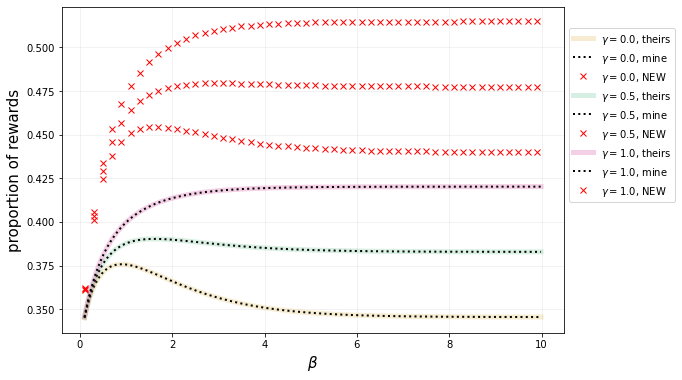

In [308]:
f, ax = plt.subplots(figsize=(9,6))

colors = ['goldenrod', 'mediumseagreen', 'mediumvioletred']
for i in [0, 1, 2]:
    ax.plot(betas, resTheir[i], color=colors[i], alpha=0.2,
            label='$\gamma={:0.1f}$, theirs'.format(gammas[i]), 
            linestyle='-', linewidth=5)
    ax.plot(betas, resMines[i], color='k', alpha=1, 
            label='$\gamma={:0.1f}$, mine'.format(gammas[i]),
            linestyle='dotted', linewidth=2)
    ax.plot(betas_NEW, resNEW[i], color='red', alpha=1, marker='x',
            label='$\gamma={:0.1f}$, NEW'.format(gammas[i]),
            linestyle='none')

    

ax.set_xlabel(r'$\beta$', size=15)
ax.set_ylabel(r'proportion of rewards', size=15)
ax.grid(alpha=0.2)
ax.legend(bbox_to_anchor=(1,.95))

# plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

# Linear rewards theo + sims

```
gamma = 0
p     = [1/4, 1/2, 3/4]
alpha = [0.2, 0.25, 0.3, 0.35, 0.4]
beta  = np.arange(0.25, 4.1, 0.25) # sims
beta  = np.arange(0.01, 4.1, 0.01) # theo
E     = 0
```

In [28]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, E  = sp.symbols('alpha beta x gamma p E')

In [29]:
p0fail = (1-p)*p1*sp.exp(-x) / (a*p*(1-sp.Min(1,sp.exp(-b+E)))+a*(1-p)*(1-sp.exp(-b)))
p0fail

p_1*(1 - p)*exp(-x)/(alpha*p*(1 - Min(1, exp(E - beta))) + alpha*(1 - p)*(1 - exp(-beta)))

In [30]:
f0failHi = a
f0failLo = a*sp.exp(-b+x)+a**2*(1-sp.exp(-b+x)) + a*(1-a)*(1-sp.exp(-b+x))*(a+(1-a)*g)
f0failLo

alpha**2*(1 - exp(-beta + x)) + alpha*(1 - alpha)*(1 - exp(-beta + x))*(alpha + gamma*(1 - alpha)) + alpha*exp(-beta + x)

In [31]:
loIntegrandFail = sp.simplify(p0fail * f0failLo)
loIntegralFail  = sp.simplify(sp.integrate(loIntegrandFail, (x, 0, b)))

In [32]:
hiIntegrandFail = sp.simplify(p0fail * f0failHi)
hiIntegralFail  = sp.simplify(sp.integrate(hiIntegrandFail, (x, b, sp.oo)))

In [33]:
p0success = p*p1*sp.exp(-x) / (a*p*(1-sp.Min(1,sp.exp(-b+E)))+a*(1-p)*(1-sp.exp(-b)))
p0success

p*p_1*exp(-x)/(alpha*p*(1 - Min(1, exp(E - beta))) + alpha*(1 - p)*(1 - exp(-beta)))

In [34]:
f0successHi = a
f0successLo = a*sp.exp(-b+E+x)+a**2*(1-sp.exp(-b+E+x)) + a*(1-a)*(1-sp.exp(-b+E+x))*(a+(1-a)*g)
f0successLo

alpha**2*(1 - exp(E - beta + x)) + alpha*(1 - alpha)*(1 - exp(E - beta + x))*(alpha + gamma*(1 - alpha)) + alpha*exp(E - beta + x)

In [35]:
loIntegrandSuccess = sp.simplify(p0success * f0successLo)
loIntegralSuccess  = sp.simplify(sp.integrate(loIntegrandSuccess, (x, 0, sp.Max(0,b-E))))

In [36]:
hiIntegrandSuccess = sp.simplify(p0success * f0successHi)
hiIntegralSuccess  = sp.simplify(sp.integrate(hiIntegrandSuccess, (x, sp.Max(0,b-E), sp.oo)))

In [37]:
full = loIntegralFail + hiIntegralFail + loIntegralSuccess + hiIntegralSuccess + p1*(3*a - a**2 + 2*a**2/(1-2*a))
full

p_1*(-alpha**2 + 2*alpha**2/(1 - 2*alpha) + 3*alpha) + Piecewise((p*p_1*((-alpha**2*gamma + alpha**2 + 2*alpha*gamma - 2*alpha - gamma)*exp(beta) + (alpha**2*gamma - alpha**2 - 2*alpha*gamma + 2*alpha + gamma)*exp(beta - Max(0, -E + beta)) + (alpha**2*gamma - alpha**2 - 2*alpha*gamma + 2*alpha + gamma - 1)*exp(E)*Max(0, -E + beta))/(p*exp(beta) - p - exp(beta) + 1), (exp(E - beta) >= 1) & Ne(-p*exp(beta) + p + exp(beta), 1)), (p*p_1*(-alpha**2*gamma + alpha**2 + 2*alpha*gamma - 2*alpha - gamma + (alpha**2*gamma - alpha**2 - 2*alpha*gamma + 2*alpha + gamma - 1)*exp(E))*Max(0, -E + beta)/(p*exp(beta) - p - exp(beta) + 1), (exp(E - beta) >= 1) | ((exp(E - beta) >= 1) & Ne(-p*exp(E) + p + exp(beta), 1))), (p*p_1*((-alpha**2*gamma + alpha**2 + 2*alpha*gamma - 2*alpha - gamma)*exp(beta) + (alpha**2*gamma - alpha**2 - 2*alpha*gamma + 2*alpha + gamma)*exp(beta - Max(0, -E + beta)) + (alpha**2*gamma - alpha**2 - 2*alpha*gamma + 2*alpha + gamma - 1)*exp(E)*Max(0, -E + beta))/(p*exp(E) - p - exp(

In [38]:
p1_solved = 1/(1/(a*p*(1-sp.Min(1,sp.exp(-b+E))) + a*(1-p)*(1-sp.exp(-b))) + 1 + (1-a)/(1-2*a))
p1_solved

1/(1 + 1/(alpha*p*(1 - Min(1, exp(E - beta))) + alpha*(1 - p)*(1 - exp(-beta))) + (1 - alpha)/(1 - 2*alpha))

In [39]:
fullLambda = sp.lambdify((a, b, g, p, E), full.evalf(subs={p1:p1_solved}))
fullLambda

<function _lambdifygenerated(alpha, beta, gamma, p, E)>

In [25]:
alphas    = [0.2, 0.25, 0.3, 0.35, 0.4]
betas     = np.arange(0.01, 4, 0.25)
ps        = [0.25, 0.5, 0.75] # using E=1
simBetas  = np.arange(0., 4.01, 0.25)
simBetas

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  ])

In [40]:
theoRes = []
for a in alphas:
    temp1 = []
    for b in betas:
        temp2 = []
        for p in ps:
            temp2.append(fullLambda(alpha=a, beta=b, gamma=0.0, p=p, E=0.))
        temp1.append(temp2)
    theoRes.append(temp1)
theoRes = np.array(theoRes)
theoRes.shape

(5, 16, 3)

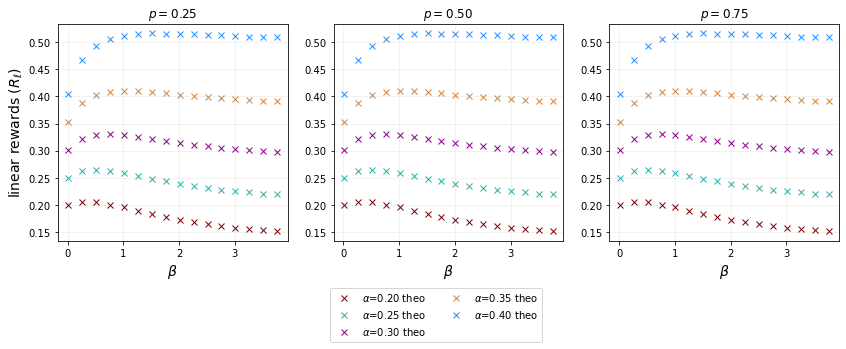

In [41]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

colors = ['maroon', 'lightseagreen', 'darkmagenta', 'peru', 'dodgerblue'] 
handles, labels = [], []

for i in range(3):
    ax = axarr[i]
    for j, a in enumerate(alphas):
        line, = ax.plot(betas, theoRes[j,:,i], linewidth=0.8, color=colors[j], marker='x', linestyle='none',
                        label=r'$\alpha$={:0.2f} theo'.format(a))
        if i == 0:
            handles.append(line)
            labels.append(r'$\alpha$={:0.2f} theo'.format(a))


for i, ax in enumerate(axarr):
    ax.grid(alpha=0.2)
    ax.set_xlabel(r'$\beta$', size=14)
    ax.set_title(r'$p=${:0.2f}'.format(ps[i]))

axarr[0].set_ylabel(r'linear rewards ($R_\ell)$', size=14)
f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=2)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()